# The compact Genetic Algorithm and TensorFlow

And what a better way to explore [TensorFlow](https://www.tensorflow.org/) than exploring howe to implement the classic _compact Genetic Algorith_ (cGA) unsing it. 



## Why is cGA interesting?

The Compact Genetic Algorithm (cGA) was proposed by Harik, Lobo, and Goldberg in 1999 [Harik1999](https://ieeexplore.ieee.org/abstract/document/797971). cCA belongs to a particular kind of evolutionary algorithms, usually named _probabilistic model-building genetic algoriths_ (also known as _estimation distribution algorithms_ or _iterated density estimation algorithms_). You can find an itroduction in this [tutorial](http://medal-lab.org/files/PMBGA_tutorial.pdf) by Pelikan.

cGA main trait is it replaces the population with a model (or distribution) of the individuals in the population. cGA assumes all bits that define an individual can be considered independent. Hence, the model is pretty simple. cGA replaces the population with probabilities table for each of the locus of the individuals. Given that if focus on binary encoded individuals, the table fore each locus only requires to model the probability of 0 and the probobility of 1. Also, given tha you only have two possible values {0, 1}, you can express $p_0$ as $p_0 = 1 - p_1$. Thus, the population model for cGA is a vector of floating point values $v \in [0, 1]$ representing the $p_1$ at any given locus.

You may wonder why is this interesting. On a traditional genetic algorith (GA) population requires proper sizing to avoid pitfalls like premature convergence. By modeling the distribution of the population instead, you can actually, given the same memory used by a traditional population, tackle a way larger problem. You may point out that the encoding of a probability is more expensive than a bit. Yes, but the memory needed as the model grows is linear only to the length of the problem _O(l)_ instead of linearly to the length of the individual times the population size _O(lp)_. Traditional GA population sizing [Golberg2002](https://dl.acm.org/doi/book/10.5555/579754) suggest that for non deceptive problems population should be set to $O(n\centerdot log(n))$, being _n_ the number of building blocks. We can appoximate for this problems $n=l$, showing that the RAM you need now grow $O(l^2\centerdot log(l))$. 

Anyway, enough of the diversion. Let's see how can we implement _cGA_ using [TensorFlow](https://www.tensorflow.org/).

## What is TensorFlow

If you go to TensorFlow (TF) [website](https://www.tensorflow.org/) the elevator pich says:

> TensorFlow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications.

As you may guess from the name, it is build around [tensors](https://en.wikipedia.org/wiki/Tensor). You can think of them as generalized multidimensional arrays. TF allows you to express and manipulate tensors to write algorithms. The framework also provide support for hardware acceleration. So, let's see how we can write _cGA_ unsing the [TensorFlow API](https://www.tensorflow.org/). 

Before you continue, please make sure you have TensorFlow installed following these [instructions](https://www.tensorflow.org/install). You may also run this notebook on Google's Colab following this [link](https://colab.sandbox.google.com/github/xllora/notebooks/blob/master/tensorflow/evolutionary_algorithms/cga.ipynb).

Once you finish the steps outline in the instruction, you should be able to run the piece of code below and get the same answer (version may vary).

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
from packaging import version
from tqdm import tqdm

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.2.0


# Solving a problem using the compact GA

The first step is to define what shape will take the individuals of our binary population. A traditional binary string would be represented by a one-dimensional tensor. For the purpose of this example, and to illustrate than cGA individuals can take any arbitrary tensor shape and size, we will model individuals as two-dimensional tensors with the given shape `(10, 10)`. 

In [0]:
import math
import functools 
import operator 

# Individual definitions.
INDIVIDUAL_SHAPE = (10, 10)
POSSIBLE_LOCI = functools.reduce(operator.mul, INDIVIDUAL_SHAPE)

# Population definitions.
POPULATION_SIZE = 10 * POSSIBLE_LOCI

# Model definitions.
MODEL_DTYPE = tf.float64
MODEL_UPDATE_FACTOR = 1.0 / POPULATION_SIZE
MODEL_MAX_ITERATION_UPDATES = int(5 * POPULATION_SIZE * math.log2(POPULATION_SIZE))

print("Indvidual tensor shape:         ", INDIVIDUAL_SHAPE)
print("Individual number of loci:      ", POSSIBLE_LOCI)
print("Population size:                ", POPULATION_SIZE)
print("Model tensor type:              ", MODEL_DTYPE)
print("Model update factor:            ", MODEL_UPDATE_FACTOR)
print("Model maximum iteration updates:", MODEL_MAX_ITERATION_UPDATES)



Indvidual tensor shape:          (10, 10)
Individual number of loci:       100
Population size:                 1000
Model tensor type:               <dtype: 'float64'>
Model update factor:             0.001
Model maximum iteration updates: 49828


There are a few definitions above. Let's break each one down.

* _INDIVIDUAL_SHAPE_: Represents the shape of the tensor that will represent a binary individual in the population. In this exampe is a 2D array of 10 entries for each dimension. You should choose the shape that will solve the problem you want to solve.
* _POSSIBLE_LOCI_: Computes the total number of positions give the individual tensor shape. In this particular example $10 \times 10 = 100$ 
* _POPULATION_SIZE_: A good rule of the thumb approximation to set the population for problems where all individual loci are independen is to set it to 10 times the possible loci. A detailed analysis you can found in [Golberg2002](https://dl.acm.org/doi/book/10.5555/579754).
* _MODEL_DTYPE_: Specifies the basic data types we are going to use to represent the loci probabilities.
* _MODEL_UPDATE_FACTOR_: The model update factor as set in [Harik1999](https://ieeexplore.ieee.org/abstract/document/797971). We will go over it with more detail below. For now, you can think of it as a way to control how much the probabilities in the model will change with each iteration.
* _MODEL_MAX_ITERATIONS_: The maximun iterations after which we should stop updating the model.  A detailed analysis of how to estimate it for GAs optimizing binary strings where each loci is considered independent can found in [Golberg2002](https://dl.acm.org/doi/book/10.5555/579754).

# The problem to solve, or the fitness function

The problem definition to solve is encapsulated in the _finess_ function. The goal of this function is to compute a 0-dimensional tensor. This function will be the one that cGA will try to maximize. 

The simplest example of a function where all loci are independent is the exhaustively studied $one\_max$. It has a simple definitien 

$$
one\_max(ind) = \sum_i{ind_i}
$$

The $one\_max$ function below implements it in TensorFlow.

In [0]:
def one_max(ind):
  return tf.reduce_sum(ind)

ind = tf.constant(
    tf.cast(
        tf.random.uniform(
            INDIVIDUAL_SHAPE,
            minval=0,
            maxval=2),
        dtype=tf.uint8))

tf.print("Individual:\n", ind)
tf.print("Fitness:   ", one_max(ind))

Individual:
 [[0 0 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 [0 1 1 ... 1 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 1]]
Fitness:    50


Using TensorFlow, $one_max$ can be just simply written as a call to `tf.reduce_sum` which returns the sum of all the values of a tensor. 

It is worth mention that the individual is modeled as `tf.costant`. This is because you can consider idividuals as values that do not change.

# Defining the cGA probabilities model


As we introduced earlier, cGA relies on a model that tracks the $p_1$ at any given locus $i$. A model is something that will change, hence, in TensorFlow you will model it as a `tf.Variable`. 



In [0]:
model = tf.Variable(tf.scalar_mul(0.5, tf.ones(INDIVIDUAL_SHAPE, dtype=MODEL_DTYPE)))

tf.print("Initial model:\n", model)

Initial model:
 [[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]


As you can see in the above example. The model is initialized with no prior knowledge, hence, all probabilities are set to $0.5$. Another way to think about the initial model as a model that assigns the same probability to all possible individuals.

# Sampling the model

cGA samples the model to generate individuals based on the model probabilities. You sample a new individual by generating a uniform random number for each locus and returning $1$ if that value is smaller that the probability of that locus, or $0$ otherwise.

In [0]:
def sample_model(model):
  return tf.cast(
      tf.math.less(
          tf.random.uniform(INDIVIDUAL_SHAPE, dtype=MODEL_DTYPE), 
          model), 
      dtype=MODEL_DTYPE)
  
tf.print("Sampled individual from the model:\n", sample_model(model))

Sampled individual from the model:
 [[0 0 0 ... 0 0 1]
 [0 0 1 ... 0 1 1]
 [1 1 1 ... 0 0 1]
 ...
 [1 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 0]]


The above `sample_model` funtion just does exactily that, but using tensors. `tf.radom_uniforn` return a random tensor with the same shape of the model. Then, these tensor is compared element-wise using `tf.math.less`. The outputh is the sampled individual as a tensor of boolean values. The final step is to cast those booleans to the same type of the model probabilities. We will see why in the following section as we define how to updade the model. 

# Updating the model

The goal of cGA is to iteratively update the model until convergence. We will conver convergece in the next section. For now, let's focus on howe we can generate one iteration update of the cGA model. The update is computed using the following steps:

1. Sample two individuals ($ind_1$, $ind_2$) from the model as we saw in `sample_model`.
2. Compute the fitness for each of the sampled individuals given the provided fitness function.
3. Compute the update towards direction indicated by the tornament winner (the individual that satisfies $argmax(fitness(ind_1), fitness(ind_2))$. If you want to minimize the fitness function instead you could just use $argmin$ instead.
4. Scale the update by `MODEL_UPDATE_FACTOR`.

You can implement this update in TensorFlow as follows.

In [0]:
def compute_udate(model, fitness):
  ind1 = sample_model(model)
  ind2 = sample_model(model)
  if fitness(ind1) < fitness(ind2):
    return tf.scalar_mul(MODEL_UPDATE_FACTOR, tf.subtract(ind2, ind1))
  else: 
    return tf.scalar_mul(MODEL_UPDATE_FACTOR, tf.subtract(ind1, ind2))

tf.print("Model update:\n", compute_udate(model, one_max))

Model update:
 [[0 -0.001 0.001 ... -0.001 0 -0.001]
 [0.001 0.001 -0.001 ... 0 0 0]
 [0 -0.001 0.001 ... 0.001 0 -0.001]
 ...
 [0 0 0.001 ... 0 0 0]
 [0 0 -0.001 ... 0 0.001 0.001]
 [0 0.001 0 ... -0.001 0.001 0.001]]


There are a two new TensorFlow operations in the code above. `tf.substract` just does point substraction of two tensors, and `tf.scalar_mult` multiplies a scalar to all values of the provided tensor. The reason why `sample_model` casted the sampled individual to the same time of the model was just intended to simplify the computation of the model update.

An interesting property of the model update is that it will only update loci where the two sampled individuals differ, updating each locus probability towards the value of the winning individual. 

At this point the only thing left is to add the update to the current model to generate the next model. The function _evolve_ below illustrate this point adding the update to the current model to create the next one using `tf.assign_add` TensorFlow operation.

In [0]:
def has_converged(model):
  return (tf.reduce_all(tf.less_equal(tf.constant(0.99, dtype=MODEL_DTYPE), model)) or
          tf.reduce_all(tf.less_equal(model, tf.constant(0.01, dtype=MODEL_DTYPE))))

def evolve(model, max_iterations, fitness, callbacks=None):
  for i in tqdm(range(max_iterations)):
    model.assign_add(compute_udate(model, fitness))
    if has_converged(model):
      break
    if callbacks:
      for c in callbacks:
        c(model)


The code above will stop if the model has converge before all `max_iterations` have been been completed. A model has converge if all the probabilitie for each each loci are either $0$ or $1$. Since we are dealing with float64 encoded values we call it converged when we pass 0.99 or 0.01 for all loci.

A bonus callback argument is provided to `evolve` intended to contain a list of callback functions. The goal of these functions is just for illustrative purposes to gather statistics of the model as it gets updated.

# Solving OneMax for (10, 10) tensor individuals

We now have all the pieces we need to solve the `one_max` problem for individuals defined as `(10, 10)` tensors. The code below show how you can call `evolve` and aso collect some statistics of how the model evolved.

In [0]:
model_summary = []

def append(model):
  model_summary.append((
      tf.reduce_min(model).numpy(), 
      tf.reduce_mean(model).numpy(), 
      tf.reduce_max(model).numpy()
  ))

evolve(model, MODEL_MAX_ITERATION_UPDATES, one_max, callbacks=[append])

tf.print("Final model:\n", model)


 27%|██▋       | 13638/49828 [00:11<00:31, 1139.33it/s]

Final model:
 [[0.99700000000000044 0.99800000000000044 1.0000000000000004 ... 0.99700000000000044 0.99800000000000044 0.99900000000000044]
 [0.99600000000000044 1.0000000000000004 0.99800000000000044 ... 0.99600000000000044 0.99800000000000044 0.99600000000000044]
 [0.99700000000000044 0.99700000000000044 1.0000000000000004 ... 0.99900000000000044 1.0000000000000004 0.99700000000000044]
 ...
 [0.99700000000000044 0.99900000000000044 0.99900000000000044 ... 1.0000000000000004 1.0000000000000004 0.99800000000000044]
 [0.99900000000000044 0.99600000000000044 0.99600000000000044 ... 0.99900000000000044 0.99900000000000044 0.99000000000000044]
 [1.0000000000000004 0.99200000000000044 0.99900000000000044 ... 0.99900000000000044 0.99600000000000044 0.99700000000000044]]


As you can see from the output above, the model converge before all `MODEL_MAX_ITERATION_UPDATES` were exhausted. 

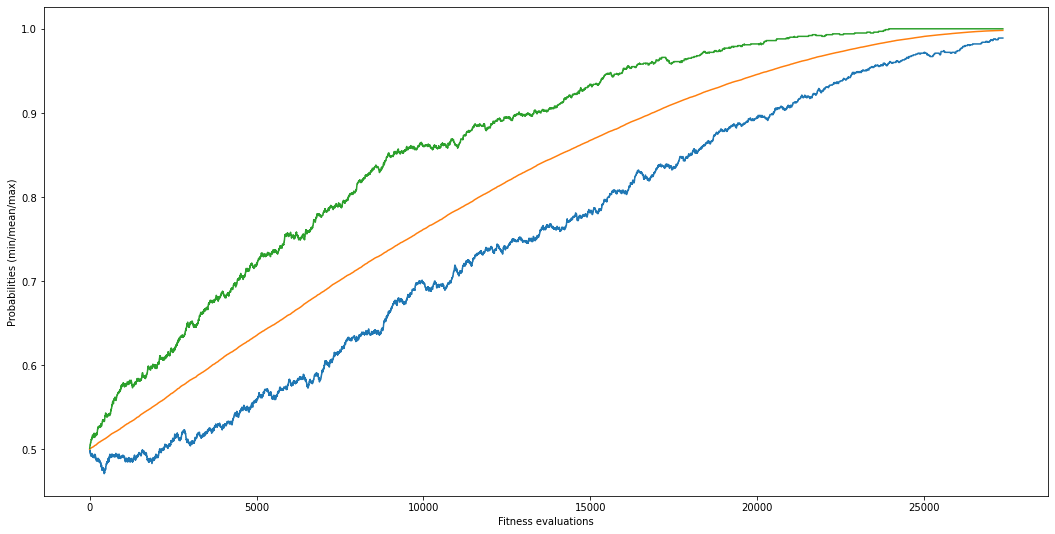

In [0]:
plt.figure(figsize=(18, 9))

x_axis = [i*2 for i in range(len(model_summary))]
y_min = [model_summary[i][0] for i in range(len(model_summary))]
y_mean = [model_summary[i][1] for i in range(len(model_summary))]
y_max = [model_summary[i][2] for i in range(len(model_summary))]
plt.plot(x_axis, y_min)
plt.plot(x_axis, y_mean)
plt.plot(x_axis, y_max)
plt.xlabel("Fitness evaluations")
plt.ylabel("Probabilities (min/mean/max)")

plt.show()

The graph above shows that the model converged for all avalable loci. It also shows that all the probabilities $p_1$ for each locus converged to $1$. This indicates that the solution to `one_max` is the `(10, 10)` tensor individual where all loci contain 1. The graphs below illustarte this point, showing the histogram of all tensor values, as well as, a color map of those values.

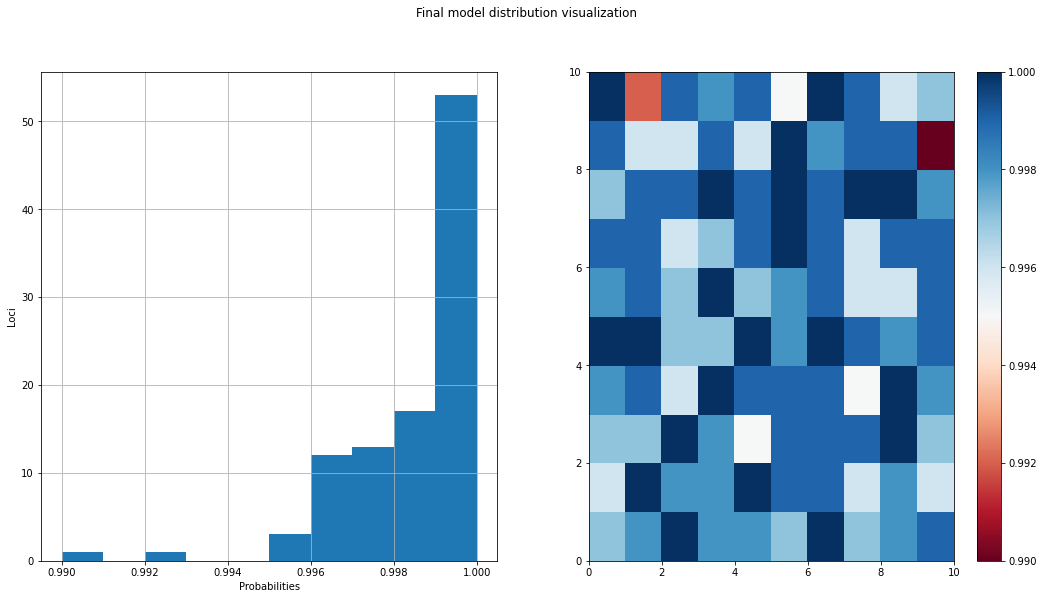

In [0]:
plt.figure(figsize=(18, 9))

if len(INDIVIDUAL_SHAPE) == 2:
    plt.subplot(121)

plt.hist(tf.reshape(model, (POSSIBLE_LOCI,) ).numpy())
plt.xlabel("Probabilities")
plt.ylabel("Loci")
plt.grid(True)
plt.suptitle("Final model distribution visualization")

if len(INDIVIDUAL_SHAPE) == 2:
    plt.subplot(122)
    plt.pcolormesh(model.numpy(), cmap='RdBu')
    plt.colorbar()

plt.show()

# Appendix

The above `evolve` code is inteded for illustrative purposes. If you want to construct a non-eagger TensorFlow graph that you can compile, just use the definition below instead.

In [0]:
@tf.function
def evolve_non_eager(model, epochs):
  for i in range(epochs):
    model.assign_add(compute_udate(model))